In [1]:
import re
import numpy as np
import pandas as pd
import calendar
from datetime import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cmlib
import matplotlib.ticker as plticker
import datetime as dt2
import seaborn as sns
import statsmodels.api as sm

WMN = 'WMN'
UNKNOWN = 'UNK'
OTHER = 'Other'

AC, FB ='AC','FB'
PE, ALK = 'PE','ALK'
PVC = 'PVC'
CI, CLCI, DI, ELCI, CLDI, GI = 'CI','CLCI', 'DI', 'ELCI', 'CLDI','GI'
IRON='Iron'

MAX_PERCEN_TOSHOW = 1

MAX_PRERanges='PreMax_Range'
LBL_MAX_PRE = 'Max pressure (m)'
LBL_PRE_FLU = 'Pressure fluctuation (m)'

INSERV_PROCESS = 'In Service'
MATERIALS_PREDOMI = [AC,PVC,IRON,PE]

Age_Range = np.arange(0, 115, 5).tolist()
AgeR_labels = [str(i) for i in np.arange(0, 110, 5).tolist()]

Diam_bins = [25 ,75, 115, 135, 165, 190, 225,275,800]
DRange_labels = ['50', '100', '125','150','175','200','250','>300']

PressMax_bins = [20,50,60,70,80,90,120]
PMaxRange_labels = ['(20,50]','(50,60]','(60,70]','(70,80]','(80,90]','(90,120]']

PressFluc_bins = [0,2.5,5,7.5,10,12.5,15,17.5,100]
PFlucRange_labels = ['(0,2.5]','(2.5,5]','(5,7.5]','(7.5,10]','(10,12.5]','(12.5,15]','(15,17.5]','(17.5,100]']

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
mpl.rcParams.update({'font.size':14, 'xtick.labelsize':14, 'ytick.labelsize':14,'axes.labelsize':14,
                     'legend.facecolor':'white'}) 

# for ppt
mpl.rcParams.update({'font.size': 22,'text.color':'white','axes.labelcolor':'white','xtick.color': 'white', 'ytick.color': 'white',
                'axes.edgecolor': 'white','axes.linewidth':3,'grid.color':'white','legend.framealpha': 0 })

In [2]:
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Verdana']

In [3]:
def getAssetsRecords():

    fname = 'Data/Assets/001-All-Assets_1.csv'
    fname2 = 'Data/Assets/001-All-Assets_2.csv'
    fname3 = 'Data/Assets/001-All-Assets_3.csv'

    AllAssets = pd.read_csv(fname, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])
    AllAssets2 = pd.read_csv(fname2, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])
    AllAssets3 = pd.read_csv(fname3, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])

    AllAssetsCom = AllAssets.append(AllAssets2).append(AllAssets3).copy()

    WaterMain = AllAssetsCom[AllAssetsCom['Asset Type Code'] == WMN].copy()

    print("There are ", WaterMain.shape[0], " water mains in the database (NOT GIS)")

    waterMains = WaterMain[~WaterMain.index.duplicated(keep='first')]

    print("There are ", WaterMain.shape[0], " water mains not duplicated in the database (NOT GIS)")
    
    #rename the index
    waterMains.index.names = ['COMPKEY']

    return waterMains


def getFailureRecords(fname,numFailureRecordsOri):
    #Reads the cvs file result from the query to the Watercare DB and store it in a dataframe
    failureRecords = pd.read_csv(fname, delimiter = ',', 
                                 usecols=[0,1,7,9,8,5],
                                 dtype = {'WONO':'str', 'ACTCODE':'str','SERVNO':'str','SR_PROB':'str',
                                          'ADDDTTM':'str', 'COMPKEY':'int64'},
                                 index_col=0,
                                 parse_dates=['ADDDTTM'],
                                )[['SERVNO','ACTCODE','SR_PROB','ADDDTTM','COMPKEY']]
    numFailureRecordsOri= failureRecords.shape[0]
    print('Number of records from the DB query:' , numFailureRecordsOri)

    failureRecords= failureRecords[~failureRecords.index.duplicated()].copy()

    print('Number of failure records:', failureRecords.shape[0], ' Deleted records duplicated WONO: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]

    #For this study if it is the same type of Repair activity on the same asset associated 
    #to the same service number and in the same date 
    #The duplicated values are due diferencees in the contractor reference numbers used to add parts of the costs.
    #therefore the duplicates are not necesary unless the cost is needed
    failureRecords.drop_duplicates(inplace=True)

    #check for duplicates using only the date (not datetime) in the extraMethods.py file!!

    print('Number of failure records:', failureRecords.shape[0], ' Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]
    return failureRecords, numFailureRecordsOri

def getFilterCodesAndSR() :

	fileACTCODE = 'Data/01-ACTCODERepair.csv'
	fileSR_Prob = 'Data/02-SR_PROB_TO_FILTER.csv'

	#read the filter files
	ACTCODERepair = pd.read_csv(fileACTCODE)
	SR_ToFilter = pd.read_csv(fileSR_Prob)

	return ACTCODERepair, SR_ToFilter

def filters3PandNotRepairs(failureRecords, SR_ToFilter, ACTCODERepair, numFailureRecordsOri):
	#filters the service codes related to third parties---------------------------------------------------------------
    failureRecords= failureRecords[~failureRecords['SR_PROB'].isin(SR_ToFilter['SR_PROB_TO_FILTER'])].copy()
    
    print('Number of failure records:', failureRecords.shape[0], ' 3P Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]


	#filters the activities with actcodes not related to repairs------------------------------------------------------
    failureRecords= failureRecords[failureRecords['ACTCODE'].isin(ACTCODERepair['ACTCODE'])].copy()
    
    print('Number of failure records:', failureRecords.shape[0], ' Not repair Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]
    
    return failureRecords, numFailureRecordsOri

def getAddressFromFailureRecords(fname):

	addressRecords = pd.read_csv(fname, delimiter = ',', 
								usecols=[0,12,13,14,15,16,17],
								dtype = {'WONO':'str', 'Street_Type':'str','Street_Name':'str','SUBURB':'str',
								'FLAT':'str','HOUSENO':'str','POSTCODE':'str'})

	addressRecords.drop_duplicates(inplace=True)
	addressRecords.set_index('WONO', inplace=True, drop=True)

	return addressRecords

def filterFailuresbyInconsistentAddress(failures, addressRecords, assetAddresses):

	#adds the compkeys to the addressess of the failure table 
    failAddr= failures.join(addressRecords)[['COMPKEY','Street_Type','Street_Name','SUBURB']]
    failAddr=failAddr.astype({'COMPKEY': 'int64'})

	#creates the table to compare addresses 
    addrComp= failAddr.join(assetAddresses, on='COMPKEY')

	#compare the suburbs and drop the values that dont match
    indexToFilter= addrComp[addrComp['SUBURB'].str.upper()!=addrComp['Suburb'].str.upper()].index
    failures.drop(indexToFilter , inplace=True)
    
    return failures

def getFailuresWithPipes(mainFailures, WMNFromAssetRecordsIndex):

	fWPipes = 'Data/00-Water_Pipe.csv'

	wPipesGIS = pd.read_csv(fWPipes, delimiter = ',', 
		                                dtype = {'COMPKEY':'int64','STATUS':'str','MATERIAL':'str',
		                                         'NOM_DIA_MM':'str','INSTALLED':'str',
                                                 'Shape_Leng' : 'float64'},
		                                usecols=[2,8,9,11,12,18],
		                                parse_dates=['INSTALLED'],
		                                index_col=['COMPKEY']
		                                )

	print("Records of pipes (GIS) ",  wPipesGIS.shape[0], " length ", "%.2f" % wPipesGIS['Shape_Leng'].sum())
	originalGIS = wPipesGIS.shape[0]
    
    #merge duplicates compkeys
	wPipesGIS = wPipesGIS.groupby(wPipesGIS.index).agg({'Shape_Leng':sum, 'STATUS': 'first', 'NOM_DIA_MM': 'first', 'MATERIAL' : 'first', 'INSTALLED':'first'})
	print("Records of pipes (GIS) ",  wPipesGIS.shape[0], " total length ", "%.2f" % wPipesGIS['Shape_Leng'].sum(),". Removed COMPKEY duplicates: ", originalGIS - wPipesGIS.shape[0])
	originalGIS = wPipesGIS.shape[0]
	
	#Delete no main pipes by the all assets dataset
	wPipesGIS = wPipesGIS[wPipesGIS.index.isin(WMNFromAssetRecordsIndex)].copy()
	print("Records of main pipes (GIS) ",  wPipesGIS.shape[0], ". Removed pipes with all assets WMN: ", originalGIS - wPipesGIS.shape[0])
	
    
	#look for the pipes of the failures and create a table with number of failure per pipe
	mainF_GISPipes= mainFailures.join(wPipesGIS, on= 'COMPKEY').copy()
	failuresWithPipesMissingInGIS = mainF_GISPipes[pd.isna(mainF_GISPipes['Shape_Leng'])].copy()
	failuresWithPipesInGIS = mainF_GISPipes[~pd.isna(mainF_GISPipes['Shape_Leng'])].copy()
	print('Failures with pipes in the GIS ', failuresWithPipesInGIS.shape[0], '. Failures with pipes missing in GIS ', failuresWithPipesMissingInGIS.shape[0])


	return failuresWithPipesInGIS, wPipesGIS


def manage_GISPipes(mainFailures,WMNFromAssetRecordsIndex):

	failuresWithPipesInGIS, wPipesGIS = getFailuresWithPipes(mainFailures,WMNFromAssetRecordsIndex)

	countNumFPerPipe = failuresWithPipesInGIS.groupby(['COMPKEY']).agg({'SERVNO': 'count', 'ACTCODE' : 'first'})
	countNumFPerPipe.rename(columns={'SERVNO':'Num of failures'}, inplace= True)


	#asign the number of failures per pipe including 0 to all the main pipe table and change formats
	wPipesGIS['NOM_DIA_MM'] = pd.to_numeric(wPipesGIS['NOM_DIA_MM'],errors='coerce')
	wPipesGISNfailures = wPipesGIS.join(countNumFPerPipe[['Num of failures']])
	wPipesGISNfailures["Num of failures"].fillna(0, inplace=True)
	wPipesGISNfailures['Shape_Leng'] = wPipesGISNfailures['Shape_Leng']/1000
	wPipesGISNfailures['MATERIAL'] = wPipesGISNfailures['MATERIAL'].replace(UNKNOWN, np.nan)
    
    #Combine AC
	wPipesGISNfailures['MATERIAL'] = wPipesGISNfailures['MATERIAL'].replace(FB, AC)
    
    #Combine PE
	wPipesGISNfailures['MATERIAL'] = wPipesGISNfailures['MATERIAL'].replace(ALK, PE)
    
    #combine CI
	wPipesGISNfailures['MATERIAL'] = wPipesGISNfailures['MATERIAL'].replace(CLCI, IRON)
	wPipesGISNfailures['MATERIAL'] = wPipesGISNfailures['MATERIAL'].replace(DI, IRON)
	wPipesGISNfailures['MATERIAL'] = wPipesGISNfailures['MATERIAL'].replace(ELCI, IRON)
	wPipesGISNfailures['MATERIAL'] = wPipesGISNfailures['MATERIAL'].replace(CLDI, IRON)
	wPipesGISNfailures['MATERIAL'] = wPipesGISNfailures['MATERIAL'].replace(GI, IRON)
	wPipesGISNfailures['MATERIAL'] = wPipesGISNfailures['MATERIAL'].replace(CI, IRON) 
    
	wPipesGISNfailures['NOM_DIA_MM'].fillna(0, inplace=True)
	wPipesGISNfailures["Age Today"] = (pd.to_datetime('today').tz_localize('UTC')-pd.to_datetime(wPipesGISNfailures["INSTALLED"])).astype('<m8[Y]')
	

	#uniStatus = failuresWithPipesInGIS['Asset Service Status'].value_counts()
	#print('Pipes with failures in GIS', uniStatus)

	#uniStatus = failuresWithPipesMissingInGIS['Asset Service Status'].value_counts()
	#print('Pipes with failures missing in GIS', uniStatus)

	return wPipesGISNfailures, failuresWithPipesInGIS


# -------------------- CONST --------------------

In [4]:
def getMaterialConst():
    
    fmaterialsConst='Data/Const-Materials.csv'

    materialsConst = pd.read_csv(fmaterialsConst, delimiter = ',', index_col=['MATERIAL'])
    
    return materialsConst

def getDiameterConst():
    
    fdiameterConst='Data/Const-Diameter.csv'

    diameterConst = pd.read_csv(fdiameterConst, delimiter = ',', index_col=['DIAMETER'])
    
    return diameterConst

def getAgeConst():
    
    fageConst='Data/Const-Ages.csv'

    ageConst = pd.read_csv(fageConst, delimiter = ',', index_col=['Age'])
    
    return ageConst

In [5]:
def getBase():
    
    fname = 'Data/03-WorkOrders.csv'
    numFailureRecordsOri = 0

    failureRecords , numFailureRecordsOri = getFailureRecords(fname,numFailureRecordsOri)
    ACTCODERepair, SR_ToFilter = getFilterCodesAndSR()

    failureRecords , numFailureRecordsOri = filters3PandNotRepairs(failureRecords, SR_ToFilter, ACTCODERepair,numFailureRecordsOri)

    #divide between MAIN and SERViCE LINES------------------------------------------------
    mainFailures = failureRecords[(failureRecords['ACTCODE']=='WMNRM') | (failureRecords['ACTCODE']=='WMNRPL')].copy()

    numFailRecordsOriM = mainFailures.shape[0]

    print('Number of failures in Mains :', numFailRecordsOriM)

    addressFromFailureRecords = getAddressFromFailureRecords(fname)
    WMNFromAssetRecords = getAssetsRecords()

    mainFailures = filterFailuresbyInconsistentAddress(mainFailures, addressFromFailureRecords, WMNFromAssetRecords)
    print('Number of failures in Mains :', mainFailures.shape[0], ' Different address Deleted records: ', numFailRecordsOriM - mainFailures.shape[0])

    numFailRecordsOriM=mainFailures.shape[0]

    #returns the shape_length in km
    wPipesGISNfailures, failuresWithPipesInGIS = manage_GISPipes(mainFailures,WMNFromAssetRecords.index.tolist())

    
    #remove non predominan materials  and sort them 
    predoMaterials = wPipesGISNfailures[wPipesGISNfailures['MATERIAL'].isin(MATERIALS_PREDOMI)].copy()
    predoMaterials.MATERIAL = pd.Categorical(predoMaterials.MATERIAL,categories= MATERIALS_PREDOMI)
    predoMaterials=predoMaterials.sort_values('MATERIAL').copy()

    failuresPMaterials= failuresWithPipesInGIS[failuresWithPipesInGIS['MATERIAL'].isin(MATERIALS_PREDOMI)].copy()
    failuresPMaterials.MATERIAL = pd.Categorical(failuresPMaterials.MATERIAL,categories= MATERIALS_PREDOMI)
    failuresPMaterials=failuresPMaterials.sort_values('MATERIAL').copy()
    
    return predoMaterials, failuresPMaterials


predoMaterials, failuresPMaterials = getBase()
consCoM = getMaterialConst()['Color']
pal=[consCoM[m] for m in MATERIALS_PREDOMI]

Number of records from the DB query: 590379
Number of failure records: 590271  Deleted records duplicated WONO:  108
Number of failure records: 570948  Deleted records:  19323
Number of failure records: 558467  3P Deleted records:  12481
Number of failure records: 92691  Not repair Deleted records:  465776
Number of failures in Mains : 14735


/home/ubuntu/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


There are  232986  water mains in the database (NOT GIS)
There are  232986  water mains not duplicated in the database (NOT GIS)
Number of failures in Mains : 13107  Different address Deleted records:  1628
Records of pipes (GIS)  619384  length  11486294.71
Records of pipes (GIS)  612465  total length  11486294.71 . Removed COMPKEY duplicates:  6919
Records of main pipes (GIS)  212535 . Removed pipes with all assets WMN:  399930
Failures with pipes in the GIS  13057 . Failures with pipes missing in GIS  50


# -------------------------- UTILS ---------------------------------------------

In [6]:
def removeTopRightFrame(ax):
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return ax

def setViolinAlpha(ax):
    
    for violin in ax.collections[::2]:
        violin.set_alpha(0.7)
        
# Only for the Facegrid distribution graph
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):

    ax = plt.gca()
    #include color=color if the labels should be colored
    ax.text(-0.05, 0.3, label, ha="left", va="center", transform=ax.transAxes)
    
def createBrokenAxisEffectNoRight(ax1, ax2):
    
    ax1.spines['bottom'].set_visible(False)
    
    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    #ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    #ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    return ax1, ax2

# --------------------INTRINSIC CHARACTERISTICS ANALYSIS--------------------

In [7]:
def putInRanges(df,colRanges,col,bins,labels,getValidationVals,startCol,finishCol):
    
    df[colRanges]= pd.cut(df[col], bins=bins, labels=labels)
    #remove invalid values (nulls)----------------------------------
    dfOK= df[~pd.isna(df[colRanges])].copy()
    
    if getValidationVals is not None:
        const= getValidationVals()
        for i in const.index:
            dfOK = dfOK.drop(dfOK[(dfOK.MATERIAL == i) & (dfOK[col]<const.loc[i, startCol])].index)
            dfOK = dfOK.drop(dfOK[(dfOK.MATERIAL == i) & (dfOK[col]>const.loc[i,finishCol])].index)
    
    print("(Main in service) Pipe length with valid ",col+" ","%.2f" % dfOK['Shape_Leng'].sum()," from original ", "%.2f" % df['Shape_Leng'].sum())
    
    return dfOK

def groupByFactor(df,colRanges,col,bins,labels,getValidationVals,startCol,finishCol):
    
    #put into ranges and group by
    if col is not None:
        dfOK= putInRanges(df,colRanges,col,bins,labels,getValidationVals,startCol,finishCol)
    else:
        dfOK= df[~pd.isna(df[colRanges])].copy()
        
    dfGroup= dfOK.groupby(['MATERIAL',colRanges]).agg({'Shape_Leng':sum, 'Num of failures':sum}).copy()
    
    #put percentage of shape leng per material
    dfGroup['%']= 0
    dfGroup['%']= dfGroup.groupby(level=0).transform(lambda x: (x*100 / x.sum()).round(2))
    
    dfGroup['Failures/Km/year']= dfGroup['Num of failures']/dfGroup['Shape_Leng']/6 
    #remove values with less than the 2% of that material
    dfGroup['Failures/Km/year']= dfGroup['Failures/Km/year'].where(dfGroup['%'] > MAX_PERCEN_TOSHOW, np.nan)
    
    return dfGroup

def getMaterialColRangeDis(df,col,rot=0,banc=(0.5, -0.13),percentage=True):
    
    #if does not have ticks then
    #sns.set_style("sticks")

    #transforming the data and getting the %
    if percentage:
        df['% of total length'] = df['Shape_Leng'] *100 / df['Shape_Leng'].sum()
        varDisplay, varName = '% of total length','% of total length'
    else:
        varDisplay, varName= 'Shape_Leng' ,"Length (km)"

    materialsColumns = df.reset_index().pivot(index=col, columns='MATERIAL', values=varDisplay)

    #start of the graph
    fig1, ax  = plt.subplots(figsize=(12,6))

    ax = materialsColumns.plot.bar( ax= ax, color= pal, rot=rot,alpha=0.7,stacked=True)

    #styling
    ax = removeTopRightFrame(ax)
    ax.legend(ncol=4, facecolor='white',fontsize=14,loc='upper center', bbox_to_anchor=banc)
    ax.set_ylabel(varName, multialignment='center');
    
    return fig1


In [8]:
def getValidationYears():
    
    consYears = getMaterialConst()[['YearIni','YearFinal']]
    consYears = consYears[consYears.index.isin(MATERIALS_PREDOMI)]
    consYears['StartAge'] = 2021-consYears['YearIni'] 
    consYears['EndAge'] = 2021-consYears['YearFinal']
    consYears['EndAge'].replace(0, np.nan, inplace=True)
    consYears.index = pd.Categorical(consYears.index,categories= MATERIALS_PREDOMI)
    consYears=consYears.sort_index()
    
    return consYears

# For pressure -------------------------------------------------------------------

In [9]:
def getFailuresWithPressures(df):

	# Join by vicinity of the shape file "Water_Pipe" from Nish with the file of preassures from Mike
    fGISPipesPressure = 'Data/09-JoinWater_PipeVsPressure.csv'

    GISpipesVsPressures = pd.read_csv(fGISPipesPressure, delimiter = ',', 
	                            dtype = {'COMPKEY':'int64', 'MOD_MAXPRE':'float64','MOD_MINPRE':'float64','Press_fluc':'float64',
                                        'Distance': 'float64'},
								usecols=[3,25,26,38,39,35],
	                            index_col=['COMPKEY'])

    GISpipesVsPressures = GISpipesVsPressures.groupby(GISpipesVsPressures.index).agg({'MOD_MAXPRE': 'mean', 'MOD_MINPRE': 'mean',
                                                                                      'Press_fluc': 'mean', 'Distance': 'mean',
                                                                                     'MODEL_NAME': 'first'})

    wPipesGISNfailuresPressure = df.join(GISpipesVsPressures)
    print("Total Length of pipes with pressure (GIS)", "%.2f" % wPipesGISNfailuresPressure['Shape_Leng'].sum(), " in ",  wPipesGISNfailuresPressure.shape[0], "records")
    assert df.shape[0] == wPipesGISNfailuresPressure.shape[0]
    
    #remove pipes without near nodes
    dfNPressures= wPipesGISNfailuresPressure[wPipesGISNfailuresPressure['Distance']<1].copy()
    print("Total Length of pipes with VALID distance to pressure (GIS)", "%.2f" % dfNPressures['Shape_Leng'].sum(), " in ",  dfNPressures.shape[0], "records")

    
    #modify the names so they match with waterModelExtent 
    dfNPressures['MODEL_NAME']= dfNPressures['MODEL_NAME'].replace('_',' ', regex=True).str.title()
    dfNPressures['MODEL_NAME']=dfNPressures['MODEL_NAME'].replace({'Greenhithe Kyle':'Greenhithe & Kyle',
                                                    'Snells Algies' :'Snells & Algies','Gptk':'GPTK','Acg':'ACG',
                                                    'Okhd':'OKHD', 'Takg':'TAKG','Cbd':'CBD'})
    
    return dfNPressures



In [10]:
def putInRangesTwoFactors(df,colRanges,col,bins,labels,colRanges2,col2,bins2,labels2):
    
    df[colRanges]= pd.cut(df[col], bins=bins, labels=labels)
    df[colRanges2]= pd.cut(df[col2], bins=bins2, labels=labels2)
    
    #remove invalid values (nulls)----------------------------------
    dfOK= df.dropna(subset=[colRanges, colRanges2]).copy()
     
    print("Pipe length with valid ",col+" and ", col2,"%.2f" % dfOK['Shape_Leng'].sum()," from original ", "%.2f" % df['Shape_Leng'].sum())
    
    return dfOK

#modified and changed the name
def groupByTwoFactorsCalibration(df,colRanges,col,bins,labels,colRanges2,col2,bins2,labels2):
    
    #put into ranges and group by    
    dfOK= putInRangesTwoFactors(df,colRanges,col,bins,labels,colRanges2,col2,bins2,labels2)
        
    dfGroup= dfOK.groupby(['MATERIAL',colRanges,colRanges2]).agg({'Shape_Leng':sum, 'Num of failures':sum, col2: 'mean',col: 'mean'}).copy()

    dfGroup= dfGroup.dropna(subset=['Shape_Leng']).copy()
    assert dfOK['Num of failures'].sum() == dfGroup['Num of failures'].sum()
    
    #put percentage of shape leng per material
    dfGroup['%']= 0
    dfGroup['%']= dfGroup.groupby(level=0).transform(lambda x: (x*100 / x.sum()).round(2))
    
    dfGroup['Failures/Km/year']= dfGroup['Num of failures']/dfGroup['Shape_Leng']/6 
    
    return dfGroup

def getRegressionLines(m,diamColumns,diamColumnsMeanPress,diamColumnsLeng,var):
    
    regres=[]
    
    for d in diamColumns.columns.tolist():
        
        y= diamColumns[d].dropna()
        X= diamColumnsMeanPress[d][diamColumnsMeanPress[d].index.isin(y.index)]
        w= diamColumnsLeng[d][diamColumnsLeng[d].index.isin(y.index)]
            
        if (not any(np.isnan(X)) and (len(y)>2)):
          
            X = sm.add_constant(X)

            model = sm.WLS(y, X,weights=w).fit() 

            #material, diameter, slope, intercept, std dev, p-value of the slope, rsquared
            regres.append([d,model.params[d], model.params['const'], 
                           model.bse[d], model.pvalues[d], model.rsquared])
    
    df=pd.DataFrame(regres, columns =[var, 'Slope', 'Intercept', 
                                      'Std dev', 'Slope P-value', 'Rsquared'])
    
    df.to_csv('Output/Regressions/'+"PressureVsFailR"+var+m+'.csv') 
    return df

In [11]:
inService = predoMaterials[predoMaterials['STATUS'] == INSERV_PROCESS].copy()
PiPress= getFailuresWithPressures(inService.copy())
PiPressAll= getFailuresWithPressures(predoMaterials.copy())

Total Length of pipes with pressure (GIS) 8569.67  in  186013 records
Total Length of pipes with VALID distance to pressure (GIS) 6569.65  in  131427 records
Total Length of pipes with pressure (GIS) 9172.63  in  198694 records
Total Length of pipes with VALID distance to pressure (GIS) 6864.60  in  137710 records


# Calibration of the conceptual model -----

In [12]:
#m of material, slp slope low pressure, slpH slope high 
def getLowAndHighPressureEquations(m,df,slp, bs,slpH,bsH):
    
    cateLow = cateSelec[m]["Low"]
    cateHigh = cateSelec[m]["High"]
    
    slp.append(df.loc[cateLow]['Slope'])
    slpH.append(df.loc[cateHigh]['Slope'])
    bs.append(df.loc[cateLow]['Intercept'])
    bsH.append(df.loc[cateHigh]['Intercept'])
    
    return slp, bs, slpH, bsH 


def dfCreateLinesRegression(df,minV,maxV):
    
    X = [minV,maxV]
    m = df['Slope']
    b = df['Intercept']
    
    y1 = m*X[0]+b
    y2 = m*X[1]+b
    
    Y = [y1,y2]
    
    return X, Y


def getTwoSegregationRegressionGraph(m,dfFail,regress,categories,colCate,xCol,name,pal):
    
    #start of the graph
    fig1, ax  = plt.subplots(1,figsize=(12,6))
    
    #for each category draw a line
    for cate, color, wds, msA  in zip(categories, pal, [0,4,0,0,4,0], [0,12,0,0,12,0]):
        
        dfFailCate = dfFail[dfFail[colCate]==cate].copy()
        
        #gets the lines of the regressions
        try:
            regCate= regress.loc[cate].copy()
            Xreg,Yreg = dfCreateLinesRegression(regCate,dfFailCate[xCol].min(),dfFailCate[xCol].max())
            
            ax.plot(Xreg, Yreg, linewidth=wds, color=color, label=(cate+"m"))
        except:
            continue
        
        #gets the original lines
        X = dfFailCate[xCol].copy()
        Y = dfFailCate['Failures/Km/year'].copy()   
        
        ax.plot(X,Y, alpha=0.9, marker='o',linewidth=0, ms=msA, color=color)
        
        
    #styling
    ax = removeTopRightFrame(ax)
    ax.legend(ncol=len(categories),fontsize=14,facecolor='white',loc='upper center',bbox_to_anchor=(.5,-.13))
    ax.set_ylim(bottom=0)
    ax.set_ylabel("Failure rate (Failures/Km/year)", multialignment='center');
    ax.set_xlabel("Age Today (years)");
    ax.grid(axis='y', which='both')
    ax.set_title(name,fontsize=14)
        
    fig1.savefig('Maps_Graph/CrackGrowthAnalysis/'+'BurstRateVsAgeByPressure'+m +'.png',
                 dpi=200, bbox_inches='tight',transparent=True)


def getBurstRateColMatPerRegression(df,colRanges,col,colBins,colLabels,colRanges2,col2,colBins2,colLabels2,label):
    
   #delete IRon older than 70 years
    df= df[~((df['MATERIAL']==IRON) & (df['Age Today']>70))].copy()

    # constants
    names = getMaterialConst()['NAME']
    #pale= cmlib.spring(np.linspace(0, 0.8, len(colLabels2)+1))
    pale=['#00D8DB','#5A68DB','#DA00DC','#DB5072','#DB8C35','#DBD900']
    
    slp, bs, slpH, bsH = [], [], [], []
    
    dfGroupDiam= groupByTwoFactorsCalibration(df,colRanges2,col2,colBins2,colLabels2,
                                      colRanges,col,colBins,colLabels)
    
    #remove values with less than the 2% of that material
    dfGroupDiam['Failures/Km/year']= dfGroupDiam['Failures/Km/year'].where(dfGroupDiam['%'] > MAX_PERCEN_TOSHOW, np.nan)
    dfGroupDiam['Shape_Leng']= dfGroupDiam['Shape_Leng'].where(dfGroupDiam['%'] > MAX_PERCEN_TOSHOW, np.nan)
    dfGroupDiam[col]= dfGroupDiam[col].where(dfGroupDiam['%'] > MAX_PERCEN_TOSHOW, np.nan)
    dfGroupDiam[col2]= dfGroupDiam[col2].where(dfGroupDiam['%'] > MAX_PERCEN_TOSHOW, np.nan)
    dfGroupDiam= dfGroupDiam.reset_index().copy()
    dfGroupDiam.dropna(subset=['Shape_Leng'],inplace=True)
    
    for m in MATERIALS_PREDOMI: 
        
        dfG= dfGroupDiam[dfGroupDiam["MATERIAL"]==m].copy()
        
        diamColumns=dfG.pivot(index=colRanges, columns=colRanges2, values='Failures/Km/year').copy()
        diamColumnsLeng=dfG.pivot(index=colRanges, columns=colRanges2, values='Shape_Leng').copy()
        diamColumnsMeanPress=dfG.pivot(index=colRanges, columns=colRanges2, values=col).copy()
         
        #regressions
        dfReg= getRegressionLines(m,diamColumns,diamColumnsMeanPress,diamColumnsLeng,label)
        dfReg.set_index('Age&Max',inplace=True)
        
        #graph in ranges 
        name = "Iron younger than 70 years" if m == IRON else names[m]
        getTwoSegregationRegressionGraph(m,dfG,dfReg,colLabels2,colRanges2,col,name,pale)
        
        #gets the slopes and ms of the high and low 
        slp, bs, slpH, bsH  = getLowAndHighPressureEquations(m,dfReg,slp,bs,slpH,bsH)
        
        
    return slp, bs, slpH, bsH , dfGroupDiam
                                           
        
def getAgeMaxPressRegreGraphs(df):
    
    Age_Range2 = np.arange(0, 110, 5).tolist()
    AgeR_labels2 = [str(i) for i in np.arange(0, 105, 5).tolist()]
    
    return getBurstRateColMatPerRegression(df,"Current age (years)","Age Today",Age_Range2,AgeR_labels2,
                         "Maximum pressure (m)","MOD_MAXPRE",PressMax_bins,PMaxRange_labels,"Age&Max")
      

Pipe length with valid  MOD_MAXPRE and  Age Today 6344.52  from original  6394.67


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


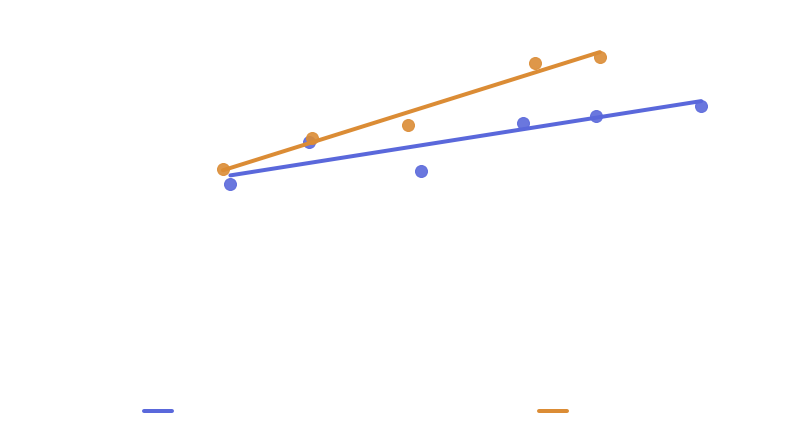

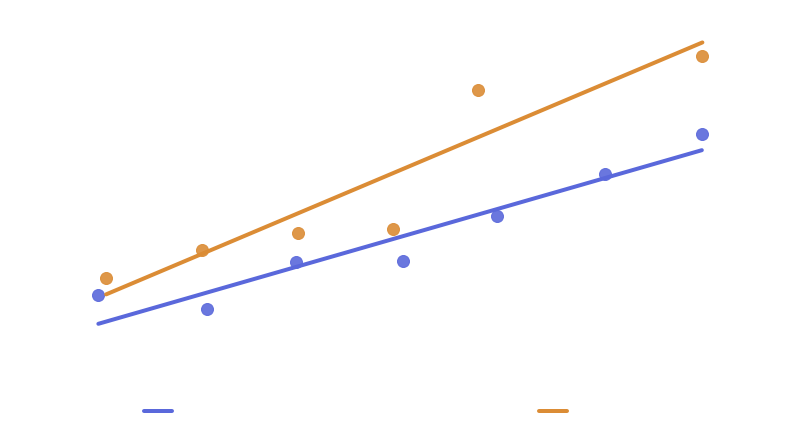

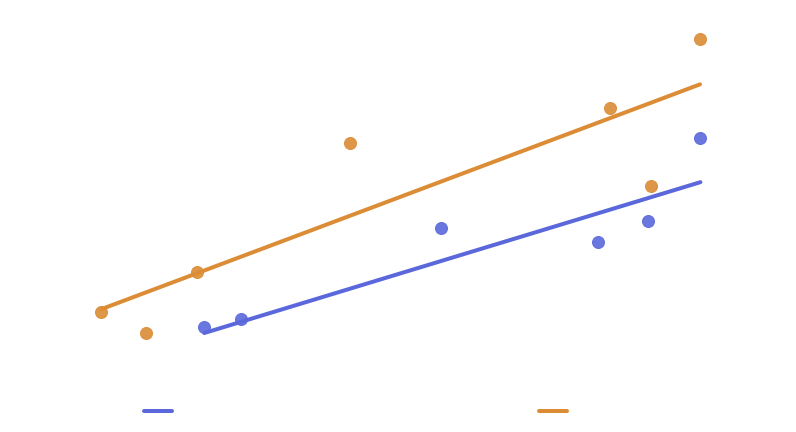

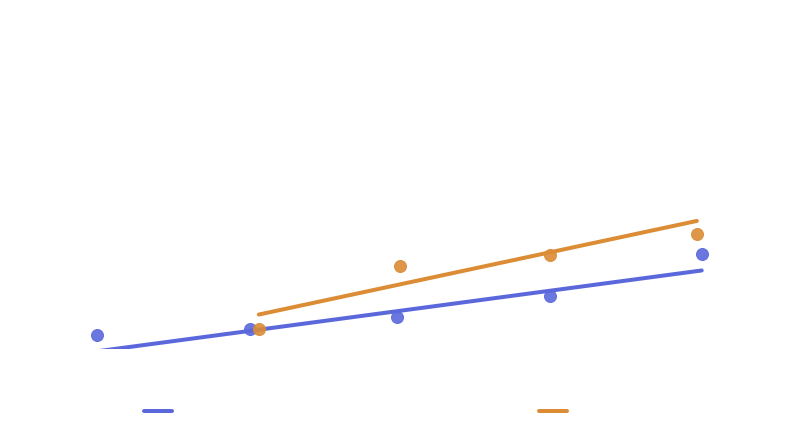

In [13]:
cateSelec = {
        AC : {
            "Low": "(50,60]",
            "High": "(80,90]"
        },
        PVC : {
            "Low": "(50,60]",
            "High": "(80,90]"
        },
        IRON : {
            "Low": "(50,60]",
            "High": "(80,90]"
        },
        PE : {
            "Low": "(50,60]",
            "High": "(80,90]"
        }
        
    }

slp, bs, slpH, bsH, dfGroup = getAgeMaxPressRegreGraphs(PiPressAll.copy())

In [14]:
def graphCountourLines(material, fails):
    
    #creates the graph
    fig1, ax  = plt.subplots(figsize=(12,6))
    nlines = len(fails)
    ax.set_prop_cycle('color',plt.cm.gist_ncar(np.linspace(0.3,1,nlines)))
    
    for f,i in zip(fails,np.arange(1, nlines, 1).tolist()):
        
        line, = ax.plot(f[0],f[1],  alpha=0.7, linewidth=2)
        if ((material == AC) & (i<=10)):
            line.set_color('0.5')
    
    #styling
    ax = removeTopRightFrame(ax)
    
    
    ax.set_ylabel("Pressure (m)")
    ax.set_xlabel("Age (year)")
    ax.set_title(material,fontsize=14 )
    
    ax.xaxis.set_minor_locator(plticker.MultipleLocator(1))
    ax.grid(axis='both', which='major')
    ax.set_xlim(0,100)
    #ax.set_ylim(15,105)#
   
    fig1.savefig('Maps_Graph/CrackGrowthAnalysis/'+ 'ConcepModCalibration' +material+'.png',
                 dpi=200, bbox_inches='tight',transparent=True)

def getFailureRateCountourLines(df,slp, bs, slpH, bsH):
      
    hMinGraph = 20
    hMaxGraph = 100

    KmPerPipe = 40
    nlines = 80
    
    dfG = df.groupby(['MATERIAL',"Maximum pressure (m)"]).agg({'MOD_MAXPRE':'mean','Shape_Leng':sum}).copy()
    #display(dfG)
      
    for mat,sL,bL,sH,bH in zip(MATERIALS_PREDOMI, slp, bs, slpH, bsH):
        
        fails = []
        
        #Gets the mean pressure in the high and low categories
        cateLow, cateHigh = cateSelec[mat]["Low"], cateSelec[mat]["High"]
        hlow, hhigh = dfG.loc[mat,cateLow].values[0], dfG.loc[mat,cateHigh].values[0]
        
        print(mat, " ", cateLow, " ",cateHigh)
        print(hlow, " ", hhigh)
        
        
        for i in np.arange(1, nlines, 1).tolist():
        
            #calculates the age at which the failure rate i ocurrs
            ageL = (i/KmPerPipe  - bL)/ sL 
            ageH = (i/KmPerPipe  - bH)/ sH
            
            #exprapolates the line for the whole pressure range
            m= (hhigh-hlow)/(ageH-ageL)
            b = hlow - (m * ageL)
            
            ageMin = (hMinGraph -b)/m
            ageMax = (hMaxGraph -b)/m
            
            failX = [ageL,ageH,ageMin,ageMax]
            failY = [hlow,hhigh, hMinGraph, hMaxGraph]
            fail = [failX,failY]
            fails.append(fail)

        graphCountourLines(mat,fails)
        


AC   (50,60]   (80,90]
55.16130648047213   84.70503370841928
PVC   (50,60]   (80,90]
55.219077298634396   85.00969219902935
Iron   (50,60]   (80,90]
54.79938287156846   85.11871768200642
PE   (50,60]   (80,90]
55.35532776950673   85.01009677821553


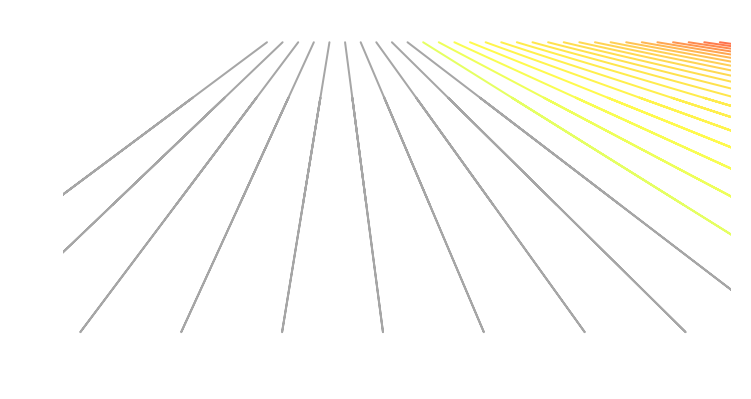

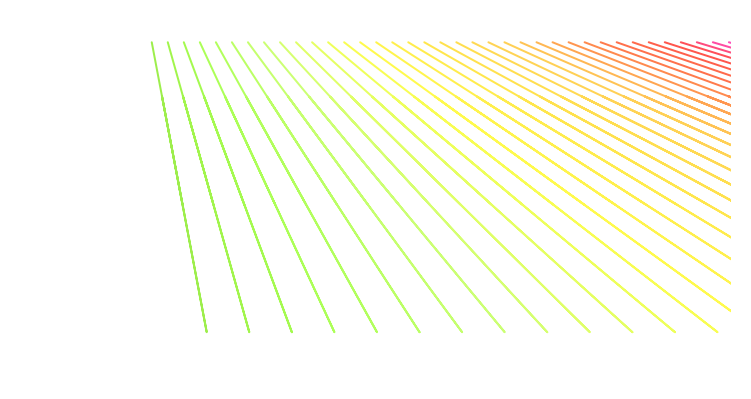

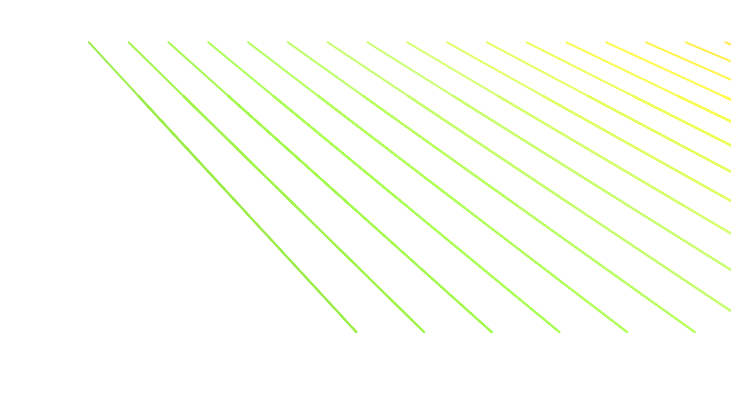

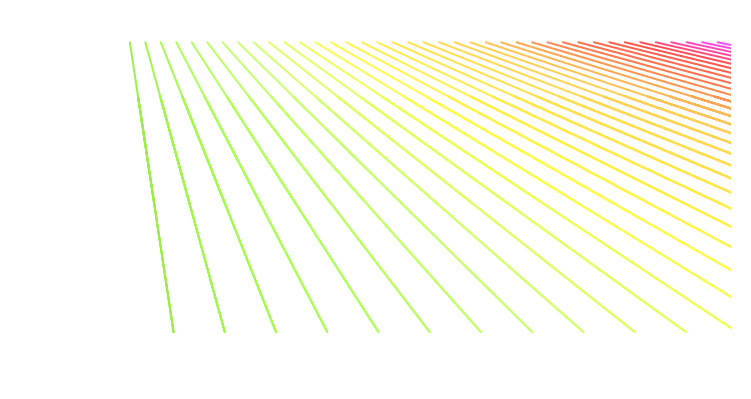

In [211]:
getFailureRateCountourLines(dfGroup.copy(), slp, bs, slpH, bsH)

In [22]:
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['xtick.bottom'] = True

In [25]:
def graphPressureIndexes(material,fails,meanAge,ymin,ymax):
    
    #creates the graph
    fig1, ax  = plt.subplots(figsize=(12,6))
    
    y0= fails[0][1][0]
    y1= fails[0][1][1]
    
    yH=70 #85 
    yl=55 #55
    ydots=[yl,yH]
        
    for f in fails:
        
        x0= f[0][0]
        x1= f[0][1]
        
        m= (y1-y0)/(x1-x0)
        b= y1 - (m * x1)
    
        xmin= (ymin - b)/m
        xmax= (ymax - b)/m
        
        xH=(yH - b)/m
        xl=(yl - b)/m
        
        ax.plot([xmin,xmax],[ymin,ymax],  alpha=0.7, linewidth=2,color='#FFD479')
        #ax.plot([xl,xH],ydots,  alpha=0.7, linewidth=0,marker='o',ms=3,color='red')
               
    #styling
    ax = removeTopRightFrame(ax)
    
    ax.set_ylabel("Pressure (m)")
    ax.set_xlabel("Age (years)")
    title = 'Asbestos cement' if material == AC else material
    ax.set_title(title,fontsize=14 )
    ax.set_xlim(meanAge,meanAge+6)
    ax.set_ylim(50,75)
    #ax.spines['left'].set_visible(False)
    
    ax.xaxis.set_major_locator(plticker.MultipleLocator(1))
    ax.grid(axis='both', which='major')
    #ax.set_xlim(0,90)
    #ax.grid(axis='both', which='both')
    
    fig1.savefig('Maps_Graph/CrackGrowthAnalysis/'+ 'ConcepModStrengIndex' +material+'.png',
                 dpi=200, bbox_inches='tight',transparent=True)
    

In [16]:
def getPressureIndexLines(df,slp,bs,slpH,bsH,yL,yH):
    
    KmPerPipe = 20
    failsPerMat = []
    failsPerMatShort = []
    meanAges = []
  
    failYs = [yL,yH]
  
    dfG = df.groupby(['MATERIAL',"Maximum pressure (m)"]).agg({'MOD_MAXPRE':'mean','Shape_Leng':sum}).copy()
    dfMeanAge= df.groupby(['MATERIAL']).agg({'Age Today': 'mean'})
    
    for mat,sL,bL,sH,bH in zip(MATERIALS_PREDOMI, slp, bs, slpH, bsH):
       
        meanAge = int(dfMeanAge.loc[mat]['Age Today'])
        fails = []
        failsShort = []
 
        #gets the lowest failure rate (low pressure) at the ageMean -1 
        FRStart= int(((meanAge-YEARLESS)*sL+bL)*KmPerPipe)
        
        print("meanA ",meanAge)
        print("FR ",FRStart)
        
        #calculates the age at which the failure rate is FRStart
        ageL = (FRStart/KmPerPipe - bL)/sL 
        ageH = (FRStart/KmPerPipe - bH)/sH
        
        #Gets the mean pressure in the high and low categories
        cateLow, cateHigh = cateSelec[mat]["Low"], cateSelec[mat]["High"]
        hlow, hhigh = dfG.loc[mat,cateLow].values[0], dfG.loc[mat,cateHigh].values[0]
        
        #gets the b and m to be able to change the y to 
        m= (hhigh-hlow)/(ageH-ageL)
        b= hlow - (m * ageL)
        
        xH= (yH-b)/m
        xL= (yL-b)/m
        
        #fail for pressure management
        failsh = [[xL,xH],failYs]
        failsShort.append(failsh)
        
        #fail long
        failY = [hlow,hhigh]
        fail = [[ageL,ageH],failY]
        fails.append(fail)
       
        while ageH < (meanAge +YEARMORE):

            TimeTofailL = 1/(ageL * sL + bL)/KmPerPipe
            TimeTofailH = 1/(ageH * sH + bH)/KmPerPipe

            ageL = ageL + TimeTofailL
            ageH = ageH + TimeTofailH
            
            m= (hhigh-hlow)/(ageH-ageL)
            b= hlow - (m * ageL)
            xH= (yH-b)/m
            xL= (yL-b)/m
            
            #fail for pressure management
            failsh = [[xL,xH],failYs]
            failsShort.append(failsh)
        
            #fail long
            fail = [[ageL,ageH],failY]
            fails.append(fail)
            
        failsPerMat.append(fails)
        failsPerMatShort.append(failsShort)
        
        graphPressureIndexes(mat,fails,meanAge,47,87)
        meanAges.append(meanAge)
    
    
    return failsPerMat,failsPerMatShort,meanAges
        

In [17]:
plt.rcParams['xtick.major.size'] = 0

meanA  53
FR  6
meanA  32
FR  2
meanA  43
FR  2
meanA  19
FR  0


/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


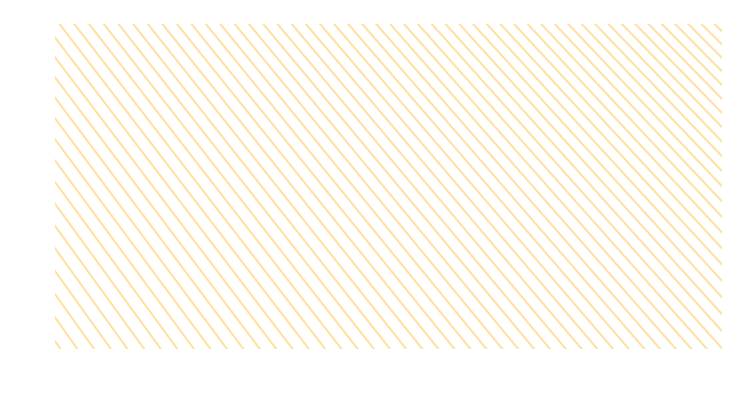

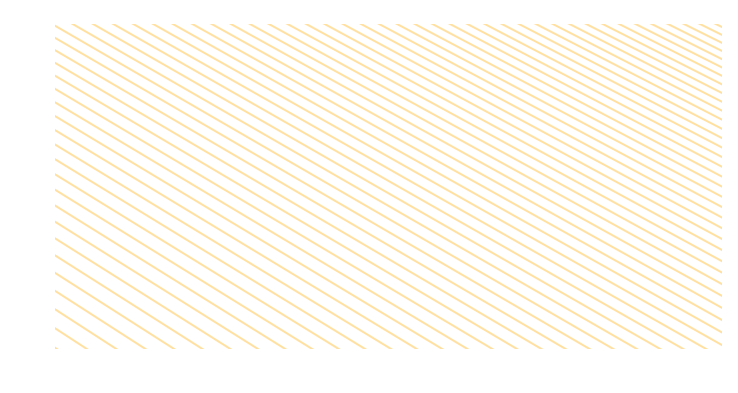

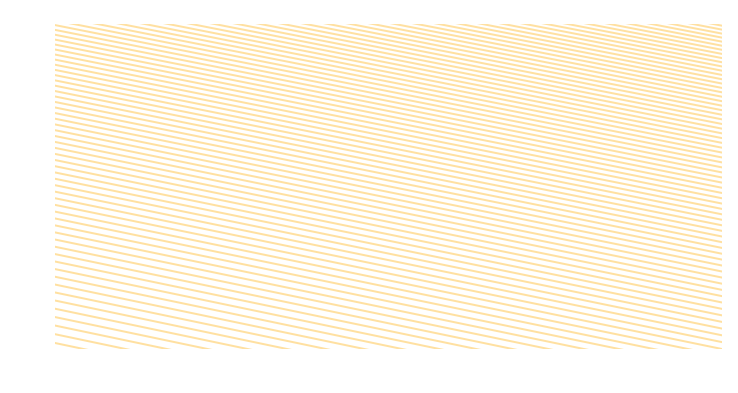

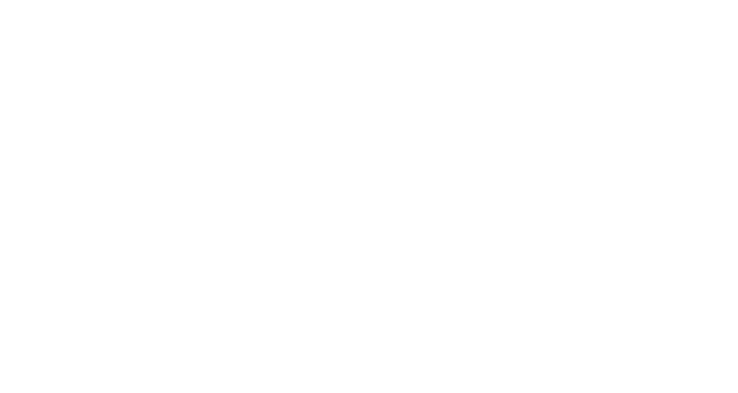

In [26]:
YEARLESS=6
YEARMORE =10
FailsListMAT,FailsSHORTListMAT,MA= getPressureIndexLines(dfGroup.copy(),slp,bs,slpH, bsH,70,55)

In [ ]:
def graphPressureManagement(material, fails,meanAge,yearsM):
    
    yPreIni = 70
    yPreFin = 55
    
    #creates the graph
    fig1, ax  = plt.subplots(figsize=(12,6))
    
    #ax.hlines(yPreIni,meanAge,meanAge+1,'r',label='Operational pressure',linewidth=4)
    #ax.hlines(yPreFin,meanAge+1,meanAge+yearsM,'r',linewidth=4)
    #ax.vlines(meanAge+1,yPreFin,yPreIni,'r',linewidth=4)
    
    yTop = yPreIni + 5
    yBot = yPreFin - 5
    
    # f[][0][] is the ages X, f[][1][] is the pressures
    # f[][][0] is for the first pressure (55), f[][][1] is for the second pressure (84)
    yTopOri = fails[0][1][1]
    yBotOri = fails[0][1][0]
    
    for f in fails:
        
        xTopOri = f[0][1]
        xBotOri = f[0][0]
        
        m= (yTopOri-yBotOri)/(xTopOri-xBotOri)
        b= yBotOri - (m * xBotOri)
        
        #gets the x for yBot
        xBot = (yBot - b)/m
        #print(material,m)
        
        #original long line 
        xPreIni= (yPreIni - b)/m
        condition = (xPreIni < (meanAge+1))
        c='0.8' if condition else '#FFD479'
        label= 'Repaired leak' if condition else 'Unrepaired leak'
        lw= 1 if condition else 3
        ax.plot([xTopOri,xBot],[yTopOri,yBot],alpha=0.7,linewidth=lw,color=c,label=label) 
        
        if condition:
            #to get the point at ymax
            xTop= (yTop - b)/m
            ax.plot([xTop,xPreIni],[yTop,yPreIni],alpha=0.7,linewidth=2,color='#FFD479') #only the top part 
  
                
    #styling
    ax = removeTopRightFrame(ax)
    
    
    lines, labels = ax.get_legend_handles_labels()  
    ax.legend([lines[len(lines)-1],lines[0],lines[len(lines)-2]],[labels[len(lines)-1],labels[0],labels[len(lines)-2]],
        ncol=3,fontsize=14,facecolor='white',loc='upper center',bbox_to_anchor=(.5,-.13))
   
    
    ax.set_ylabel("Pressure (m)")
    ax.set_xlabel("Age (years)")
    #title = 'Iron younger than 70 years' if material == IRON else material
    title = 'Asbestos cement' if material == AC else material
    ax.set_title(title,fontsize=14 )
   
    ax.xaxis.set_major_locator(plticker.MultipleLocator(1))
    ax.grid(axis='both', which='both')
   
    ax.set_xlim(meanAge,meanAge+yearsM)
    ax.set_ylim(yBot,yTop)
    
   
    fig1.savefig('Maps_Graph/CrackGrowthAnalysis/'+ 'ConcepModPressMana' +material+'.png',
                 dpi=200, bbox_inches='tight',transparent=True)
  

In [ ]:
for m,fails,ma,yM in zip(MATERIALS_PREDOMI,FailsListMAT,MA,[4,6,11,4]):

    graphPressureManagement(m, fails,ma,yM)

In [182]:
def graphFailureRChange(failureRateVar):
    
     #creates the graph
    fig1, ax  = plt.subplots(figsize=(12,6))
    
    for m,fv,c in zip(MATERIALS_PREDOMI,failureRateVar, pal):
    
    #for ppt
    #m,fv,c = MATERIALS_PREDOMI[1],failureRateVar[1], pal[1]
        
        ax.plot(fv[0],fv[1],marker='o',linewidth=5, ms=12,alpha=0.7,label=m,color=c)
        ax.plot(fv[0][YEARLESS:],fv[2][YEARLESS:],linewidth=4, ls=":",alpha=0.7,color=c)
        
    
    #just for the label
    ax.plot([1],[0],linewidth=2, ls=":",label="Without PM",alpha=0.9,color='w')
    
    ax = removeTopRightFrame(ax)
    ax.set_ylim([-1,11])#
    ax.set_xlim([-3.9,14.9])#
    ax.xaxis.set_major_locator(plticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(plticker.MultipleLocator(2))
    ax.grid(axis='y', which='both')
    ax.spines['left'].set_visible(False)
    ax.set_ylabel("Number of failures")
    ax.set_xlabel("Year in relation to the pressure management")
    ax.set_title("Pressure management from 70m to 55m",fontsize=14)
    
    ax.legend(ncol=5,fontsize=14,
              facecolor='white',loc='upper center',bbox_to_anchor=(.5,-.13))
    
    fig1.savefig('Maps_Graph/CrackGrowthAnalysis/'+ 'PressureManaEffect' +'.png',
                 dpi=200, bbox_inches='tight',transparent=True)   


def getCountFailures(indexesMat, meanAgesMat):
    
    failChanges = []
    
    for m,agePM,indexes in zip(MATERIALS_PREDOMI,meanAgesMat,indexesMat):
        
        years = []
        failsy = []
        failsyH = []
        i=-YEARLESS
    
        for y in np.arange(agePM-YEARLESS, agePM+YEARMORE, 1).tolist():

            numFail = 0
            numFailHigh = 0

            for f in indexes:

                # f[0][] is the ages X, f[1][] is the pressures
                # f[][0] is for the first pressure (55), f[][1] is for the second pressure (84)
                ageH = f[0][1]
                ageL = f[0][0]

                if (y <= agePM):
                     if (y == int(ageH)):
                        numFail = numFail +1
                        numFailHigh = numFailHigh +1
                else:
                    if ((y == int(ageL)) & (int(ageH) > agePM)):
                        numFail = numFail +1
                        
                    if y == int(ageH):
                        numFailHigh = numFailHigh +1
        
            
            years.append(i)
            failsy.append(numFail)
            failsyH.append(numFailHigh)
            i=i+1
        
        failChanges.append([years,failsy,failsyH])

    graphFailureRChange(failChanges)
            

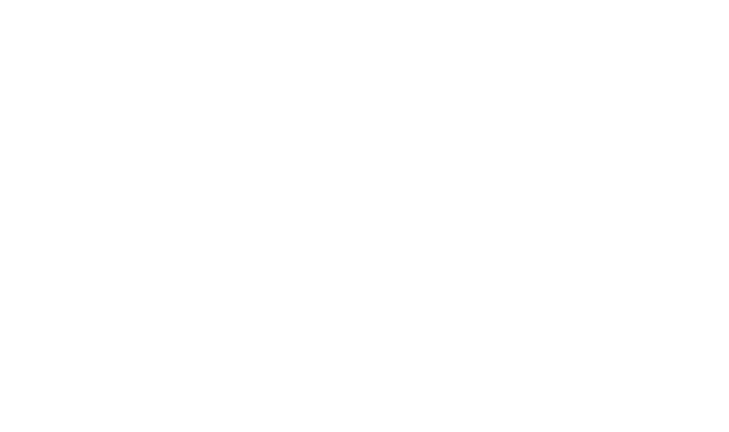

In [183]:
#sns.set_style("ticks")
getCountFailures(FailsSHORTListMAT,MA)
    

meanA  53
FR  6
meanA  32
FR  3
meanA  43
FR  2
meanA  19
FR  1


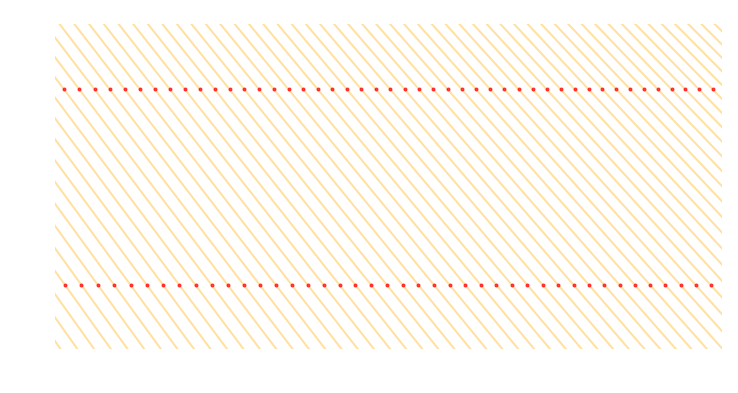

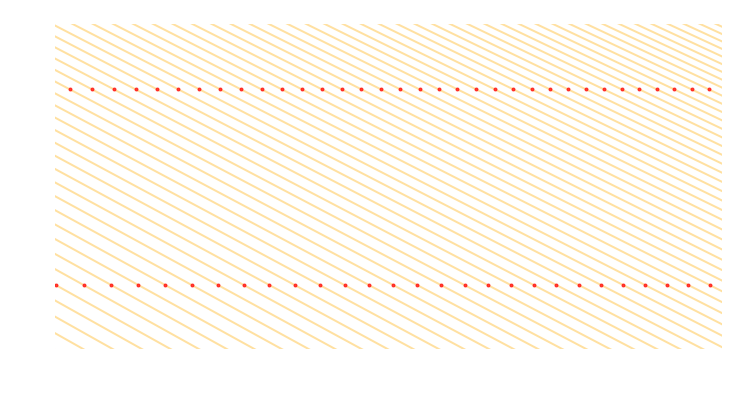

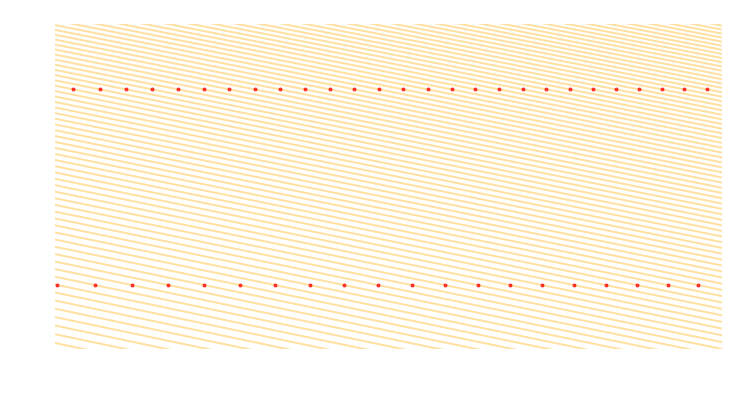

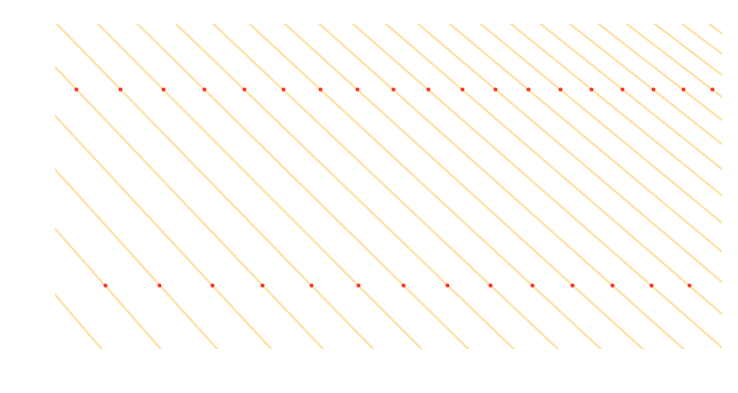

In [20]:
YEARLESS=3
YEARMORE =14
yHI=70
yLO=55
FailsListMAT,FailsSHORTListMAT,MA= getPressureIndexLines(dfGroup.copy(),slp,bs,slpH, bsH,yLO,yHI)

In [34]:
def getCountFailures(indexes, year):
    
    numFailHigh = 0
    numFailLow = 0
    
    for f in indexes:
         
        # f[0][] is the ages X, f[1][] is the pressures
        # f[][0] is for the first pressure (55), f[][1] is for the second pressure (85)
        ageH = f[0][1]
        ageL = f[0][0]
         
        if year == int(ageH):
            numFailHigh = numFailHigh +1
            
        if year == int(ageL):
            numFailLow = numFailLow +1
    
            
    return numFailHigh, numFailLow

In [36]:
failsAC= FailsSHORTListMAT[0]

for y in np.arange(43, 63, 1).tolist():

    nfailsHigh, nfailsLow= getCountFailures(failsAC, y)
    
    print(y, nfailsHigh, nfailsLow)

43 2 0
44 12 0
45 13 12
46 13 13
47 13 12
48 13 13
49 13 13
50 14 13
51 14 13
52 15 13
53 14 14
54 15 14
55 16 14
56 15 14
57 16 15
58 16 15
59 16 14
60 17 16
61 17 15
62 17 15
